In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm
from itertools import combinations

In [2]:
Npix = 2**12
Npad = 2**8
Nfft = Npix*Npad

def freq2lam(freq_MHz):
    return 3e8/(freq_MHz*1e6)

def image2uv(image):
    assert(len(image)==Npix)
    bigimage = np.zeros(Npix*Npad)
    bigimage[:Npix//2] = image[-Npix//2:]
    bigimage[-Npix//2:] = image[:Npix//2]
    return rfft(bigimage)

def uv2image(uv):
    #print (len(uv))
    assert(len(uv) == Nfft//2+1)
    bigimage = irfft(uv)
    image = np.hstack((bigimage[-Npix//2:],bigimage[:Npix//2]))
    return image

def alpha():
    return (np.arange(-Npix//2,Npix//2)+0.5)*(2/Npix)

def DoL():
    return np.arrange(Nfft//2+1)/Npad/2

def empty_uv():
    return np.zeros(Nfft//2+1,np.complex)

def empty_image():
    return np.zeros(Npix,np.float)

def DoL2ndx (DoL):
    return int(DoL*Npad*2+0.5) ## nearest integer

def primary_beam_1(D,freq_MHz):
    lam = freq2lam(freq_MHz)
    t=empty_uv()
    t[:DoL2ndx(D/lam/2)]=1.0
    return uv2image(t)

[]

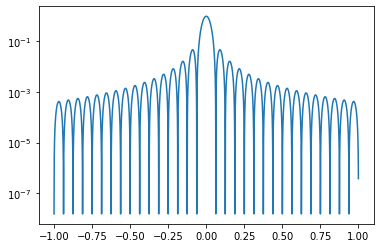

In [3]:
pbeam = primary_beam_1(6,800)**2 
plt.plot(alpha(),pbeam/pbeam.max())
plt.semilogy()

In [4]:
## Telescope sim

Nfreq = 256
freqs = np.linspace(400,800,Nfreq)
Ndishes = 32
lams = freq2lam(freqs)
DDish = 6
## this is a now 2D array of (numfreqs x Nbaselines) containg D/lambda for each
#DoLams = np.outer(1/lams, DDish*np.arange(0,Ndishes))
## this is now an array of indices in the uv plane
#indices = (DoLams*Npad*2+0.5).astype(int)

In [5]:
# Make array not redundant; distances between two consecutive dishes are D, 1.25*D, 1.5*D, 1.75*D, 2*D, repeat
dish_locations = np.arange(0,Ndishes,dtype=float)
for ii in np.arange(1,Ndishes):
    #distance = DDish # This makes redundant array
    distance = DDish*((ii-1)%5*0.25+1) # This is D, 1.25*D, 1.5*D, 1.75*D, 2*D, D, 1.25*D, ... for ii = 1, 2, ...
    dish_locations[ii] = dish_locations[ii-1]+distance

# Get every baseline combination, compile unique baseline lengths (include 0)
baseline_lengths = np.array([d2-d1 for d1, d2 in combinations(dish_locations, 2)])
unique_baseline_lengths = np.unique(baseline_lengths)
unique_baseline_lengths = np.insert(unique_baseline_lengths, 0, 0)

# 2D array of (N freqs x N unique baselines) containg D/lambda for each
DoLams = np.outer(1/lams, unique_baseline_lengths)

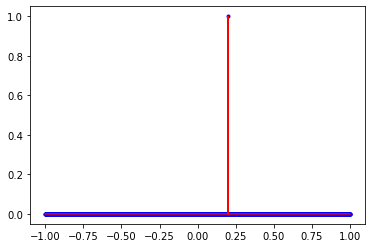

In [6]:
## Let's find a response to a point source
image = empty_image()
ndx = int(Npix*60/100)
image[ndx] = 1
plt.plot(alpha(),image,'b.')
plt.plot(alpha(),uv2image(image2uv(image)),'r-')
al = alpha()[ndx]
image.shape,Npix
## let's ignore beam for now
uv=image2uv(image)
#uvplane = uv[indices]

In [7]:
indices = (DoLams*Npad*2+0.5).astype(int)
# Instead of using indices = (DoLams*Npad*2+0.5).astype(int) (nearest neighbor apprach) use linear interpolation
indices_true = (DoLams*Npad*2+0.5)
# Use indices_true rather than indices
uvplane = np.zeros_like(indices_true, np.complex)
for ii, idx_vals in enumerate(indices_true):
    for jj, idx_val in enumerate(idx_vals):
        # Looping through every element of indices_true
        val1 = uv[np.floor(idx_val).astype(int)]
        val2 = uv[np.ceil(idx_val).astype(int)]
        # For example, if the idx_val is 1.2, we'd do 0.2*(uv[2]-uv[1]) + uv[1]
        val = (idx_val%1) * (val2-val1) + val1
        uvplane[ii,jj] = val

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'visibility')

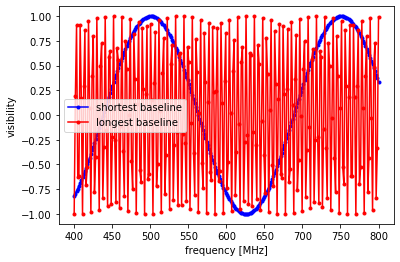

In [8]:
plt.plot(freqs,uvplane[:,1],'b.-', label='shortest baseline')

plt.plot(freqs,uvplane[:,-1],'r.-', label='longest baseline')
plt.legend()
plt.xlabel('frequency [MHz]')
plt.ylabel('visibility')

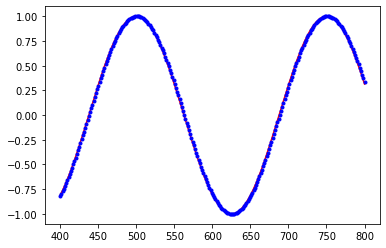

In [9]:
#compare with analytics
direct = np.cos(DDish/lams*2*np.pi*al)
plt.plot(freqs,direct,'r-')
plt.plot(freqs,uvplane[:,1],'b.')

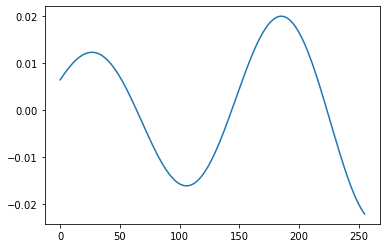

In [10]:
## we can now see interpolation errors. The scheme is percent accurate
plt.plot(direct-np.real(uvplane[:,1]))

In [11]:
## let's try to image this back
rmap = []
halfindices = (indices[:,:-1]+indices[:,1:])//2
halfindices = np.hstack((halfindices,2*indices[:,-1:]-halfindices[:,-1:]))
for i,f in enumerate(freqs):
    uvi=empty_uv()
    #for k in range(1,Ndishes):
    #    uvi[halfindices[i,k-1]:halfindices[i,k]]=uvplane[i,k]
    uvi[indices[i,1:]] = uvplane[i,1:]
    rmap.append(uv2image(uvi))
rmap = np.array(rmap)

# Make version with phase errors
rmap_obs = []
# Add time errors; each antenna's phase error sampled from Gaussian with mean 0, sigma 10 picoseconds
time_errors = np.random.normal(0,10e-12,Ndishes)
for i,f in enumerate(freqs):
    phase_errors = time_errors*f*1e6*2*np.pi
    # Get and average all the observed visibilities for each of the unique baselines
    for j, baseline_len in enumerate(unique_baseline_lengths[1:]):
        redundant_baseline_idxs = np.where(baseline_lengths==baseline_len)[0]
        uvplane_obs = []
        for k in redundant_baseline_idxs:
            dish1_loc, dish2_loc = list(combinations(dish_locations, 2))[k]
            dish1_idx = np.where(dish_locations==dish1_loc)[0][0]
            dish2_idx = np.where(dish_locations==dish2_loc)[0][0]
            uvplane_obs.append((np.exp(1j*(phase_errors[dish2_idx]-phase_errors[dish1_idx])))*uvplane[:,j+1])
        uvplane_obs = np.array(uvplane_obs, np.complex)
        uvplane[:,j+1] = np.mean(uvplane_obs, axis=0)
    uvi=empty_uv()
    uvi[indices[i,1:]] = uvplane[i,1:]
    rmap_obs.append(uv2image(uvi))
rmap_obs = np.array(rmap_obs)

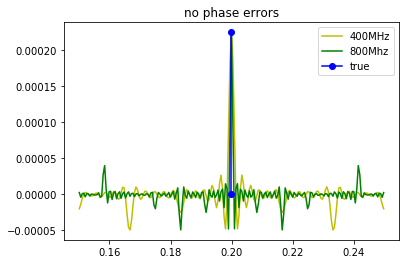

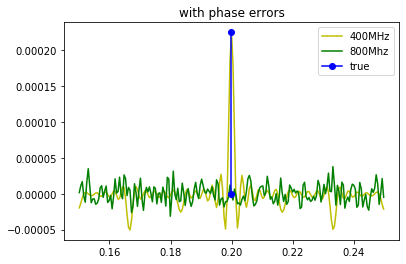

In [12]:
alp = alpha()
wal = np.where((alp>al-0.05) & (alp<al+0.05))
plt.plot(alpha()[wal],rmap[0,wal[0]],'y-',label='400MHz')
plt.plot(alpha()[wal],rmap[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap.max()],'bo-',label='true')
plt.title('no phase errors')
plt.legend()
plt.show()

alp = alpha()
wal = np.where((alp>al-0.05) & (alp<al+0.05))
plt.plot(alpha()[wal],rmap_obs[0,wal[0]],'y-',label='400MHz')
plt.plot(alpha()[wal],rmap_obs[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_obs.max()],'bo-',label='true')
plt.title('with phase errors')
plt.legend()
plt.show()

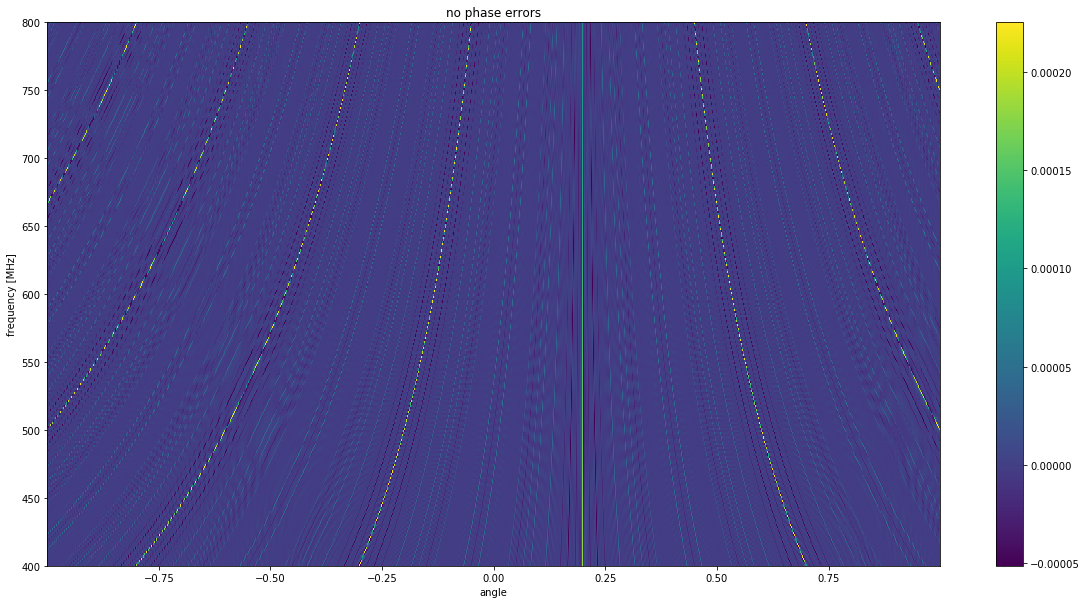

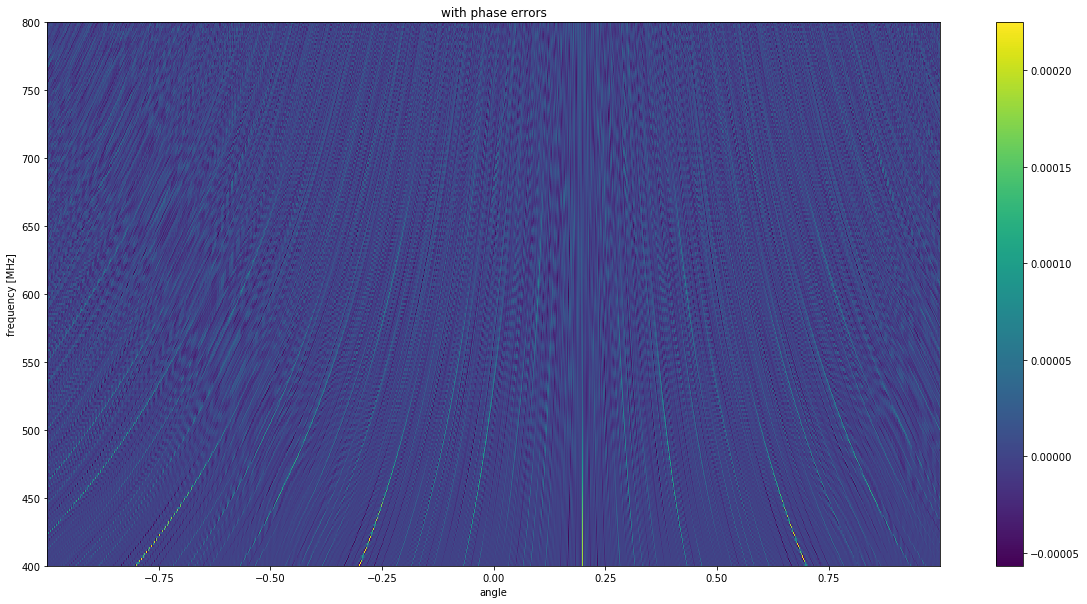

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(rmap,aspect='auto',origin='lower',extent=(alpha()[0],alpha()[-1],freqs[0],freqs[-1]))
plt.ylabel('frequency [MHz]')
plt.xlabel('angle')
plt.title('no phase errors')
plt.colorbar()
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(rmap_obs,aspect='auto',origin='lower',extent=(alpha()[0],alpha()[-1],freqs[0],freqs[-1]))
plt.ylabel('frequency [MHz]')
plt.xlabel('angle')
plt.title('with phase errors')
plt.colorbar()
plt.show()

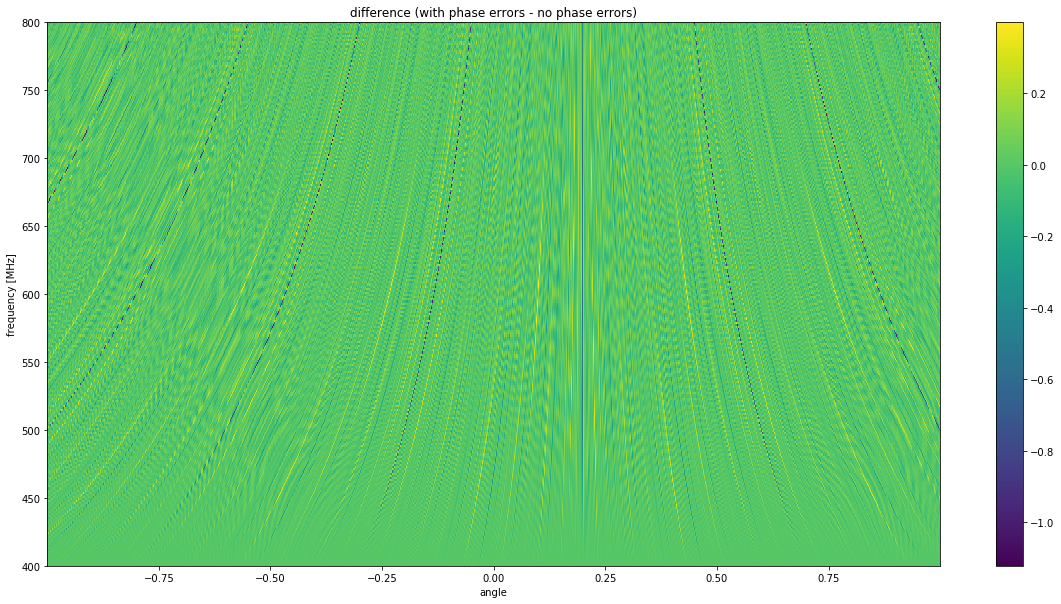

In [14]:
# Plot difference between rmap with and without phase errors (normalized)
plt.figure(figsize=(20,10))
plt.imshow(rmap_obs/rmap.max() - rmap/rmap.max(),aspect='auto',origin='lower',extent=(alpha()[0],alpha()[-1],freqs[0],freqs[-1]))
plt.ylabel('frequency [MHz]')
plt.xlabel('angle')
plt.title('difference (with phase errors - no phase errors)')
plt.colorbar()

In [15]:
## Now let's plot some wedge.

### now we will just simulate various skies with point sources, which are flat in frequency, so only one FFT
### then do the fft along the frequency direction and hopefully see the wedge. WE need to do this for many realizations of the
### sky to get statistics

Nrel = 100
# Assuming redundant array 
DoLams = np.outer(1/lams, DDish*np.arange(0,Ndishes))
indices = (DoLams*Npad*2+0.5).astype(int)

## let's make dishes smaller to see horizon more clearly -- hence 1/5 below
p2fac = [np.abs(primary_beam_1(DDish,f)**2)/np.cos(alpha()) for f in freqs]
uvplane = np.zeros((Nfreq,Ndishes),np.complex)
ps = np.zeros((Nfreq+1,Ndishes)) ## 2*Nfreq //2  +1 = Nfreq+1
for c in range(Nrel):
    ## create a random sky, this sky will be the same at all frequencies
    sky = np.random.uniform(0,1,Npix)
    ## loop over frequencies
    for i,f in enumerate(freqs):
        ## multiply by the beam ** 2 / cos
        msky = sky * p2fac[i]
        ## FT to the uvplane and sample at indicies corresponding to dist/lam 
        ## for this frequencies for the sate of dishes that we have
        uvplane[i,:]=image2uv(msky)[indices[i,:]]
    ## after uvplan is done, calculate ps in the frequency direction -- this gives delay spectrum
    for j in range(Ndishes):
        ps[:,j] += np.abs(rfft(np.hstack((uvplane [:,j],np.zeros(Nfreq))))**2)

/usr/lib/python3/dist-packages/numpy/fft/_pocketfft.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


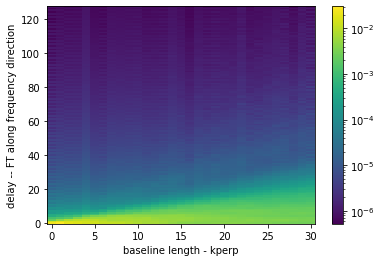

In [16]:
plt.imshow(ps[:128,1:],origin='lower',aspect='auto',interpolation='nearest', norm=LogNorm())
plt.xlabel("baseline length - kperp")
plt.ylabel("delay -- FT along frequency direction")
plt.colorbar()